# Machine Translation

English-German Translation

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
# What's life without style :). So, let's add style to our dataframes
#from IPython.core.display import HTML
#css = open('style-table.css').read() + open('style-notebook.css').read()
#HTML('<style>{}</style>'.format(css))

In [0]:
import pandas as pd 
import string 
import pickle
from pickle import dump
from pickle import load
from string import digits
import re 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from numpy import array, argmax, random, take 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [4]:
from keras.models import Model
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding,Input,RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 

Using TensorFlow backend.


In [5]:
!  pip install version_information

In [6]:
# first install: pip install version_information
%reload_ext version_information
%version_information pandas,re,sklearn, matplotlib,keras

Software versions
Python 3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython 5.5.0
OS Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas 0.24.2
re 2.2.1
sklearn 0.21.3
matplotlib 3.0.3
keras 2.2.5
Fri Sep 13 11:55:12 2019 UTC

# 2)- Reading Dataset

In [0]:
df= pd.read_table('random_data.txt', names=['eng','ger'])

In [8]:
df.shape

(6507, 2)

In [9]:
df[30:35]

,eng,ger
30,when the united states occupied japan after world war ii general douglas macarthur and his aides encouraged the country to adopt a constitution designed to assure that hideki tojos militarized aut...,als die vereinigten staaten nach dem zweiten weltkrieg japan besetzte ermutigten general douglas mac arthur und sein stab das land dazu eine verfassung zu verabschieden die sicherstellen solle das...
31,fully aware that workers and their unions had a role to play in shaping the new japan they included language that explicitly recognized that the right of workers to organize and to bargain and act...,in vollem bewusstsein dessen dass die arbeiter und ihre gewerkschaften bei der schaffung eines neuen japan eine rolle einnahmen verwendeten sie eine sprache die explizit anerkannte dass die rechte...
32,when the united states occupied germany after world war ii general dwight david eisenhower and his aides urged the germans to write a constitution that would assure that adolf hitlers fascism was ...,als die vereinigten staaten nach dem zweiten weltkrieg deutschland besetzen drangten general dwight david eisenhower und sein stab die deutschen eine verfassung zu schreiben die dafur sorgen wurde...
33,recognizing that workers would need to organize and make their voices heard in the new nation the germans included a provision that explicitly declared the right to form associations to safeguard ...,in anerkennung der tatsache dass die arbeiter sich wurden organisieren mussen und ihre stimme in der neuen nation erheben sollten fugten die deutschen eine klausel ein die explizit aussagte das re...
34,agreements that restrict or seek to impair this right shall be null and void measures directed to this end shall be unlawful,vereinbarungen die dieses recht einschranken oder darauf abzielen es zu schmalern sind null und nichtig darauf abzielende manahmen sind ungesetzlich


# 3)- Quick Preprocessing

In [0]:
# Lowercase all characters
df.eng=df.eng.apply(lambda x: x.lower())
df.ger=df.ger.apply(lambda x: x.lower())

In [0]:
# Remove quotes
df.eng=df.eng.apply(lambda x: re.sub("'", '', x))
df.ger=df.ger.apply(lambda x: re.sub("'", '', x))

In [0]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df.eng=df.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df.ger=df.ger.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [0]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df.eng=df.eng.apply(lambda x: x.translate(remove_digits))
df.ger=df.ger.apply(lambda x: x.translate(remove_digits))

In [0]:
# Remove extra spaces
df.eng=df.eng.apply(lambda x: x.strip())
df.ger=df.ger.apply(lambda x: x.strip())
df.eng=df.eng.apply(lambda x: re.sub(" +", " ", x))
df.ger=df.ger.apply(lambda x: re.sub(" +", " ", x))

In [0]:
# Add start and end tokens to target sequences. I am not German so , I am doing so for my ease
df.ger = df.ger.apply(lambda x : 'START_ '+ x + ' _END')

In [16]:
df.ger[70:73]

70    START_ dr jordan sagte dass das alter einer frau bei der diagnose der typ des eierstockkrebses bestehende vorerkrankungen sowie der soziale und wirtschaftliche status ebenfalls die uberlebenschanc...
71                                                    START_ fur altere frauen und diejenigen deren krebs zum diagnosezeitpunkt bereits weiter fortgeschritten war lag die uberlebensrate am niedrigsten _END
72              START_ fur diejenigen die in landlichen und abgelegenen regionen des staates lebten lag das sterblichkeitsrisiko wahrend der studie um prozent hoher als fur diejenigen in stadtgebieten _END
Name: ger, dtype: object

In [17]:
df.sample(10)

,eng,ger
5087,prime minister thomas thabane fled the country saying the countrys military had surrounded his official home and seized government buildings in the capital of maseru,START_ premierminister thomas thabane floh aus dem land und teilte mit dass die armee des landes seinen amtswohnsitz umzingelt und regierungsgebaude in der hauptstadt maseru besetzt habe _END
5926,the messed up toll is dead bernd riexinger the party leader told the neuen osnabrucker zeitung newspaper on monday,START_ die murksmaut ist tot sagte parteichef bernd riexinger der neuen osnabrucker zeitung montag _END
1085,in goddard reported that service shafts and piping ducts behind parliamentary committee rooms were contaminated with asbestos whose lethal fibres could be disturbed by something as innocuous as st...,START_ berichtete goddard dass die serviceschachte und rohrleitungen hinter den ausschussraumen des parlaments mit asbest verseucht waren dessen todliche fasern durch etwas so harmloses wie starke...
3797,businesses state and local tax burdens last year expanded by percent to billion compared with percent the year before and it was the third consecutive year of growth after backtoback years of shri...,START_ die staatliche und ortliche steuerlast der unternehmen stieg im vergangenen jahr um prozent auf milliarden an im vergleich zu prozent im jahr zuvor und es war das dritte wachstumsjahr in fo...
3856,before his career in politics the new senior politician li yiwei worked for an american company which is highly unusual in the chinese communist party,START_ der neue spitzenpolitiker li yiwei hatte vor seiner parteikarriere fur ein amerikanisches unternehmen gearbeitet was hochst ungewohnlich in der kommunistischen partei chinas ist _END
5667,for black women like mitchell who have studied race gender and sexuality in us history there is no dichotomy between issues regarding race and gender,START_ fur schwarze frauen wie mitchell die rasse geschlecht und sexualitat in der geschichte der usa studiert haben gibt es keine dichotomie zwischen rassen und geschlechterproblemen _END
3546,leonidas begged in the gladiatorial arena,START_ leonidas bat in die gladiatorenarena _END
5234,i cant understand how it happens because if you ask people noone wants a war so how does it happen,START_ ich kann nicht verstehen wie das moglich ist denn wenn sie die menschen fragen will niemand einen krieg also wie geschieht das _END
1946,after its second win of the season hutteldorf is in third place on the table,START_ hutteldorfer nach zweitem saisonsieg auf platz drei der tabelle _END
4914,mr pidgley added demand for the right product with good design in the best locations has remained resilient and reflecting this forward sales have been maintained,START_ herr pidgley fugte hinzu die nachfrage nach dem richtigen gut geplanten produkt an den besten standorten blieb stabil und als ergebnis sind auch die terminverkaufe stabil geblieben _END


### 3a)- Vocab Size

In [0]:
# Vocabulary of English
all_eng_words=set()
for eng in df.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
# Vocabulary of German 
all_german_words=set()
for ger in df.ger:
    for word in ger.split():
        if word not in all_german_words:
            all_german_words.add(word)

In [19]:
# Max Length of source sequence
import numpy as np
lenght_list=[]
for l in df.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

71

In [20]:
# Max Length of target sequence
lenght_list=[]
for l in df.ger:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

73

In [21]:
df['word_eng'] = df['eng'].apply(lambda x: len(str(x).split(" ")))
df[['eng','word_eng']].sample(3)

,eng,word_eng
6491,florian zierz from frankfurt got himself into the saddle at am he did the feldberg twice before then wheeling back home,21
1719,its one thing to look over your friends shoulder at in the morning as she creeps through resident evil and quite another to watch some rando get headshots in a row in call of duty,35
326,it wasnt until my mum was poorly near the end of her life that we started saying i love you i love you i love you,26


In [22]:
# adding +2 due to adding of START and END
df['word_ger'] = df['ger'].apply(lambda x: len(str(x).split(" ")))
df[['ger','word_ger']].sample(3)

,ger,word_ger
3421,START_ es ist der ideale isolationsstoff fur die dampfmaschinen und turbinen der industriellen revolution _END,15
2953,START_ als fanatische islamistische terroristen kinder und eltern am september dem beginn eines neuen schuljahrs gefangen nahmen und toteten schien das wie das boseste des bosen _END,27
3244,START_ es wurde fur dachplatten fubodenplatten rohrisolationen boilerisolierungen sogar fur bremsbelage in autos verwendet _END,15


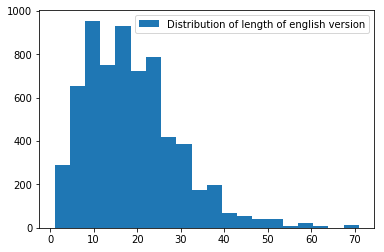

In [23]:
words_eng=df['word_eng']
plt.hist(words_eng, bins=20, label="Distribution of length of english version") 
plt.legend() 
plt.show()

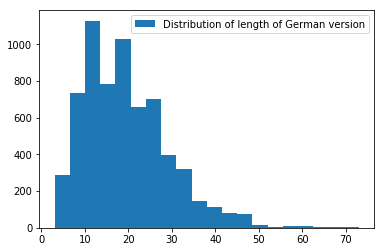

In [24]:
words_ger=df['word_ger']
plt.hist(words_ger, bins=20, label="Distribution of length of German version") 
plt.legend() 
plt.show()

### 3b)-Words' frequency

In [25]:
# let’s check the 10 most frequently occurring words in our English text data
freq_eng = pd.Series(' '.join(df['eng']).split()).value_counts()[:10]
freq_eng

the     7929
to      3345
of      3234
in      3045
and     2859
a       2709
for     1269
that    1230
is      1200
was     1146
dtype: int64

In [26]:
freq_ger = pd.Series(' '.join(df['ger']).split()).value_counts()[:12]
freq_ger

_END      6507
START_    6507
die       3768
der       3531
und       2820
in        2370
den       1359
von       1299
das       1278
zu        1218
fur        999
dass       996
dtype: int64

As we have start and end words so, I did check 12 so that we get idea of most fequent words

**How about least occuring words**

In [27]:
less_freq_eng = pd.Series(' '.join(df['eng']).split()).value_counts()[-10:]
less_freq_eng

tenth        3
select       3
outwards     3
luxurious    3
slugs        3
clay         3
collapsed    3
sophomore    3
bump         3
crippling    3
dtype: int64

In [28]:
less_freq_ger = pd.Series(' '.join(df['ger']).split()).value_counts()[-10:]
less_freq_ger

konkurrenz           3
bain                 3
tolz                 3
dickkopf             3
gesetzesvorschlag    3
wachtersbach         3
uberlebenszeit       3
tankstelle           3
erneuern             3
vornehmlich          3
dtype: int64

### 3a)- Defining input and target

In [29]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_german_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_german_words)
num_encoder_tokens, num_decoder_tokens

(7230, 9285)

In [30]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

9286

In [0]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [0]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [33]:
print(reverse_input_char_index)

{1: 'a', 2: 'abandon', 3: 'abandoned', 4: 'abbott', 5: 'abbotts', 6: 'abc', 7: 'abdulmalik', 8: 'abe', 9: 'abilities', 10: 'ability', 11: 'able', 12: 'abortion', 13: 'abortions', 14: 'about', 15: 'above', 16: 'absence', 17: 'absentmindedly', 18: 'absolutely', 19: 'abstract', 20: 'abuse', 21: 'academics', 22: 'academy', 23: 'accelerated', 24: 'accept', 25: 'acceptable', 26: 'accepted', 27: 'access', 28: 'accident', 29: 'accidents', 30: 'acclaim', 31: 'acclaimed', 32: 'accommodate', 33: 'accommodated', 34: 'accommodation', 35: 'accompanying', 36: 'accordance', 37: 'according', 38: 'accordingly', 39: 'account', 40: 'accounts', 41: 'accusations', 42: 'accused', 43: 'accuses', 44: 'accusing', 45: 'achenbach', 46: 'aches', 47: 'achieve', 48: 'achieved', 49: 'achievement', 50: 'achievements', 51: 'achieving', 52: 'achilles', 53: 'acknowledge', 54: 'acknowledges', 55: 'acquire', 56: 'acquired', 57: 'acquiring', 58: 'acquitted', 59: 'acrobatics', 60: 'across', 61: 'act', 62: 'acting', 63: 'acti

In [34]:
print(reverse_target_char_index)

{1: 'START_', 2: '_END', 3: 'a', 4: 'ab', 5: 'abbildung', 6: 'abbog', 7: 'abbott', 8: 'abbotts', 9: 'abbruch', 10: 'abc', 11: 'abdulmalik', 12: 'abe', 13: 'abend', 14: 'abends', 15: 'aber', 16: 'aberkannt', 17: 'abfahrt', 18: 'abfindung', 19: 'abgaben', 20: 'abgebildete', 21: 'abgehalten', 22: 'abgehoben', 23: 'abgelegenen', 24: 'abgelegener', 25: 'abgenommen', 26: 'abgeordneten', 27: 'abgeordnetenkammer', 28: 'abgeordneter', 29: 'abgeschlossen', 30: 'abgeschossen', 31: 'abgeschreckt', 32: 'abgesetzt', 33: 'abgesprungene', 34: 'abgestellt', 35: 'abgestiegen', 36: 'abgetrennt', 37: 'abgewandt', 38: 'abhangigen', 39: 'abhilfe', 40: 'abkommen', 41: 'abkuhlt', 42: 'ablauf', 43: 'ablehnt', 44: 'ablehnte', 45: 'about', 46: 'abreien', 47: 'abriss', 48: 'abschaffung', 49: 'abscheu', 50: 'abscheuliche', 51: 'abschied', 52: 'abschluss', 53: 'abschlusse', 54: 'abschlussstudent', 55: 'abschwungs', 56: 'absichtlich', 57: 'absolut', 58: 'absolute', 59: 'absoluten', 60: 'absoluter', 61: 'absolvieren'

### 3b)-Train - Test Split

For validation

In [35]:
X, y = df.eng, df.ger #X being input, y being target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape, X_test.shape

((5205,), (1302,))

**Save the train and test dataframes for reproducing the results later, as they are shuffled**

In [0]:
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [0]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# 4)-Encoder - Decoder Model Architecture

In [0]:
latent_dim = 50

In [39]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [41]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

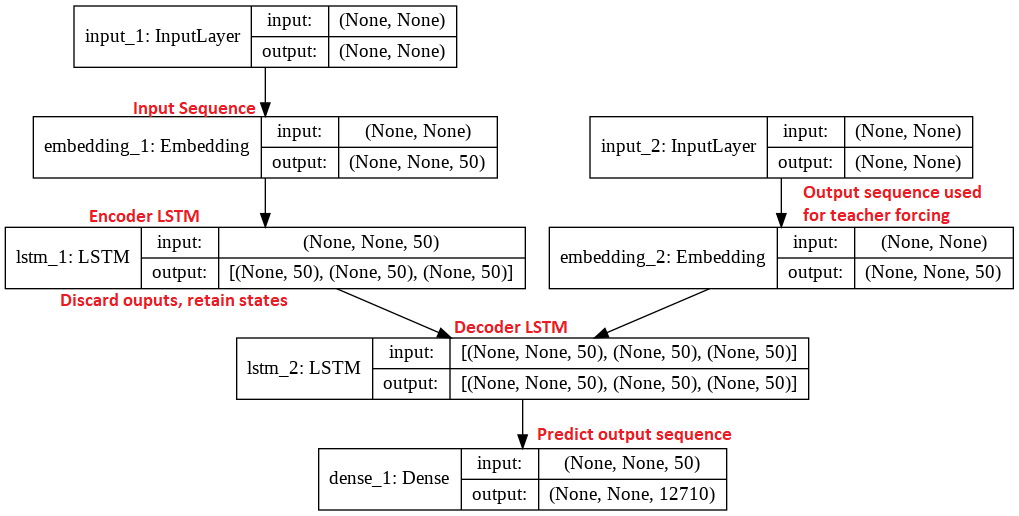

In [42]:
# just to give a picture of how multiple lstm work on each side of encoder and decoder
from IPython.display import Image
Image(retina=True, filename='train.png')

In [0]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 15

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     361500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 50)     464300      input_2[0][0]                    
____________________________________________________________________________________________

In [45]:
history=model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)


Epoch 1/15
40/40 [==============================] - 34s 838ms/step - loss: 8.1033 - acc: 0.0359 - val_loss: 7.3058 - val_acc: 0.0318
Epoch 2/15
40/40 [==============================] - 30s 754ms/step - loss: 7.1638 - acc: 0.0543 - val_loss: 7.1617 - val_acc: 0.0542
Epoch 3/15
40/40 [==============================] - 30s 747ms/step - loss: 7.1032 - acc: 0.0552 - val_loss: 7.1564 - val_acc: 0.0543
Epoch 4/15
40/40 [==============================] - 31s 769ms/step - loss: 7.0516 - acc: 0.0553 - val_loss: 7.1071 - val_acc: 0.0546
Epoch 5/15
40/40 [==============================] - 31s 781ms/step - loss: 6.9920 - acc: 0.0551 - val_loss: 7.0514 - val_acc: 0.0549
Epoch 6/15
40/40 [==============================] - 31s 782ms/step - loss: 6.9296 - acc: 0.0553 - val_loss: 7.0038 - val_acc: 0.0542
Epoch 7/15
40/40 [==============================] - 32s 804ms/step - loss: 6.8754 - acc: 0.0575 - val_loss: 6.9543 - val_acc: 0.0562
Epoch 8/15
40/40 [==============================] - 32s 793ms/step -

In [0]:
# save model
model.save_weights('translate.h5')

In [0]:
model.load_weights('translate.h5')

# 5)-Inference Setup

In [0]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Decode sample sequeces

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']
  

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# 6)-Evaluation on Validation Dataset

In [0]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [51]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual German Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted German Translation:', decoded_sentence[:-4])

Input English sentence: garden centres rue fall in homeowners
Actual German Translation:  gartenzentren bedauern sinkende hausbesitzerzahlen 
Predicted German Translation:  es 


# 7)- Plotting results

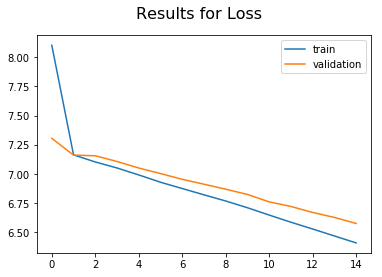

In [52]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.suptitle('Results for Loss', fontsize=16)
plt.show()

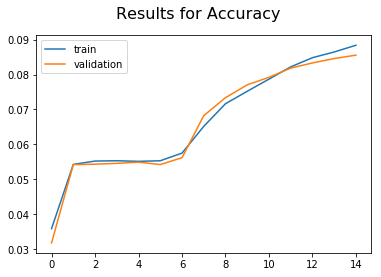

In [53]:
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.legend(['train','validation']) 
plt.suptitle('Results for Accuracy', fontsize=16)
plt.show()